
Netflix Stock Price Prediction System
------------------------------------

[1/4] Loading and preprocessing data...

Sample of processed data:
             open   high    low  close           adj_close        volume  \
date                                                                       
2002-05-24 1.2143 1.2250 1.1971 1.2100  1.2100000381469727 11104800.0000   
2002-05-28 1.2136 1.2321 1.1571 1.1571   1.157142996788025  6609400.0000   
2002-05-29 1.1643 1.1643 1.0857 1.1036  1.1035710573196411  6757800.0000   
2002-05-30 1.1079 1.1079 1.0714 1.0714  1.0714290142059326 10154200.0000   
2002-05-31 1.0786 1.0786 1.0714 1.0764   1.076429009437561  8464400.0000   

            daily_return  price_change  volatility  
date                                                
2002-05-24        0.0113       -0.0043      0.0279  
2002-05-28       -0.0437       -0.0564      0.0750  
2002-05-29       -0.0463       -0.0607      0.0786  
2002-05-30       -0.0291       -0.0364      0.0364  
2002-

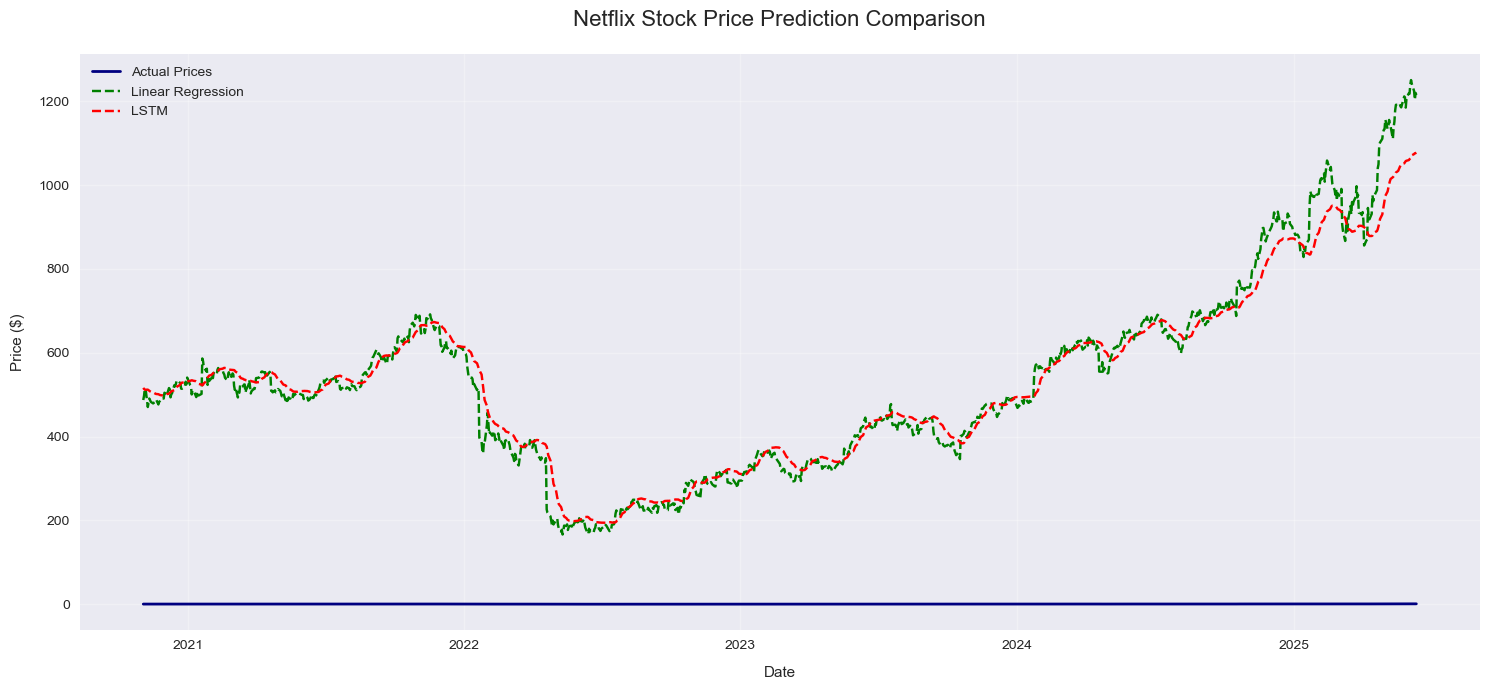


Analysis complete!


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
pd.set_option('display.float_format', '{:.4f}'.format)


TIME_STEPS = 20  
TEST_SIZE = 0.2 
RANDOM_STATE = 42

def load_and_preprocess_data(filepath):
    """Load and preprocess the stock data"""
    try:
        df = pd.read_csv(filepath)
        
        df.columns = [col.lower().strip() for col in df.columns]

        required_cols = ['date', 'open', 'high', 'low', 'close', 'volume']
        if not all(col in df.columns for col in required_cols):
            missing = set(required_cols) - set(df.columns)
            raise ValueError(f"Missing required columns: {missing}")
        
        numeric_cols = ['open', 'high', 'low', 'close', 'volume']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date').sort_index()
        
        df['daily_return'] = df['close'].pct_change()
        df['price_change'] = df['close'] - df['open']
        df['volatility'] = df['high'] - df['low']
        
        df = df.dropna()
        
        return df
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def prepare_linear_regression_data(df):
    """Prepare data for linear regression"""
    features = ['open', 'high', 'low', 'volume', 'daily_return', 'price_change', 'volatility']
    target = 'close'
    
    X = df[features]
    y = df[target]
    
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=TEST_SIZE, shuffle=False
    )
    
    return X_train, X_test, y_train, y_test, scaler

def train_linear_regression(X_train, y_train):
    """Train and evaluate linear regression model"""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"\n{model_name} Performance:")
    print(f"- MSE: {mse:.6f}")
    print(f"- MAE: {mae:.6f}")
    print(f"- R²: {r2:.4f}")
    
    return predictions

def create_lstm_dataset(data, time_steps):
    """Create time-series dataset for LSTM"""
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 3]) 
    return np.array(X), np.array(y)

def prepare_lstm_data(df):
    """Prepare data for LSTM model"""
    features = ['open', 'high', 'low', 'close', 'volume', 'daily_return', 'price_change', 'volatility']
    data = df[features].values
    

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X, y = create_lstm_dataset(scaled_data, TIME_STEPS)
    
    train_size = int(len(X) * (1 - TEST_SIZE))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler

def build_lstm_model(input_shape):
    """Build LSTM model architecture"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    
    return model

def plot_results(actual, lr_pred, lstm_pred, dates):
    """Visualize model predictions"""
    plt.figure(figsize=(15, 7))
    
    min_length = min(len(actual), len(lr_pred), len(lstm_pred), len(dates))
    actual = actual[:min_length]
    lr_pred = lr_pred[:min_length]
    lstm_pred = lstm_pred[:min_length]
    dates = dates[:min_length]
    
    plt.plot(dates, actual, label='Actual Prices', color='navy', linewidth=2)
    plt.plot(dates, lr_pred, label='Linear Regression', linestyle='--', color='green')
    plt.plot(dates, lstm_pred, label='LSTM', linestyle='--', color='red')
    
    plt.title('Netflix Stock Price Prediction Comparison', pad=20, fontsize=16)
    plt.xlabel('Date', labelpad=10)
    plt.ylabel('Price ($)', labelpad=10)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    print("\nNetflix Stock Price Prediction System")
    print("------------------------------------")
    
    data_file = 'NFLX_stocks.csv'
    if not os.path.exists(data_file):
        print(f"\nError: Data file '{data_file}' not found in current directory")
        print("Please ensure the file exists or provide the correct path")
        return
    
    print("\n[1/4] Loading and preprocessing data...")
    df = load_and_preprocess_data(data_file)
    
    if df is None:
        print("\nFailed to load data. Please check:")
        print("1. The file exists and is accessible")
        print("2. The file contains all required columns")
        print("3. Numeric columns contain valid numbers")
        return
    
    print("\nSample of processed data:")
    print(df.head())

    print("\n[2/4] Training Linear Regression model...")
    X_train_lr, X_test_lr, y_train_lr, y_test_lr, lr_scaler = prepare_linear_regression_data(df)
    lr_model = train_linear_regression(X_train_lr, y_train_lr)
    lr_predictions = evaluate_model(lr_model, X_test_lr, y_test_lr, "Linear Regression")
    
    print("\n[3/4] Training LSTM model...")
    X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, lstm_scaler = prepare_lstm_data(df)
    
    lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        epochs=100,
        batch_size=32,
        validation_data=(X_test_lstm, y_test_lstm),
        callbacks=[early_stopping],
        verbose=1
    )
    
    lstm_predictions_scaled = lstm_model.predict(X_test_lstm)
    
    dummy_data = np.zeros((len(lstm_predictions_scaled), X_test_lstm.shape[2]))
    dummy_data[:, 3] = lstm_predictions_scaled.flatten()
    lstm_predictions = lstm_scaler.inverse_transform(dummy_data)[:, 3]
    
    test_dates = df.index[-len(y_test_lstm):]
    
    min_length = min(len(y_test_lstm), len(lr_predictions[-len(y_test_lstm):]), len(lstm_predictions), len(test_dates))
    y_test_plot = y_test_lstm[-min_length:]
    lr_pred_plot = lr_predictions[-min_length:]
    lstm_pred_plot = lstm_predictions[-min_length:]
    test_dates_plot = test_dates[-min_length:]
    
    print("\n[4/4] Generating results visualization...")
    plot_results(
        actual=y_test_plot,
        lr_pred=lr_pred_plot,
        lstm_pred=lstm_pred_plot,
        dates=test_dates_plot
    )
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()